In [2]:
#import sys
#!{sys.executable} -m pip install imblearn

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import recall_score, accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest
from collections import Counter

import matplotlib.ticker as mtick #for showing percentage in it

In [2]:
data=pd.read_csv(r'C:\Users\tusha\Documents\Data Science\Python\Telco Customer Churn\WA_Fn-UseC_-Telco-Customer-Churn.csv')
data_backup=data.copy()
data.head()
'''
https://www.kaggle.com/datasets/blastchar/telco-customer-churn
'''
#dataset information

'\nhttps://www.kaggle.com/datasets/blastchar/telco-customer-churn\n'

In [3]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
data['TotalCharges']=pd.to_numeric(data['TotalCharges'],errors='coerce')

In [6]:
numerical_feature=[feature for feature in data.columns if data[feature].dtypes!='O']
print(numerical_feature)

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [7]:
categorical_feature=[feature for feature in data.columns if data[feature].dtypes=='O']
print(f' Length of the categorical features is {len(categorical_feature)} \n and categorical features are {categorical_feature} ')

 Length of the categorical features is 17 
 and categorical features are ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn'] 


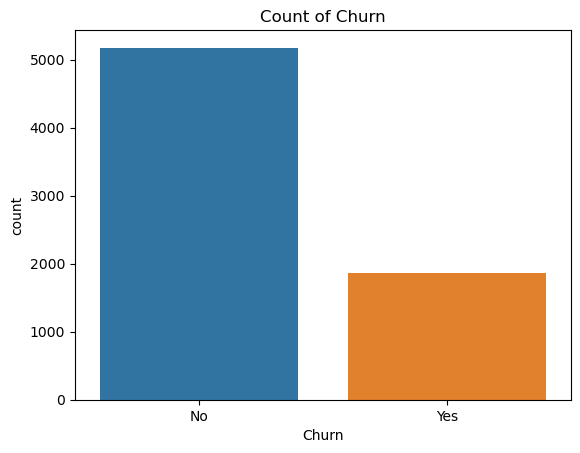

In [8]:
sns.countplot(data=data,x='Churn')
plt.title('Count of Churn')
plt.show()

In [9]:
data['Churn'].value_counts(normalize=True)*100 
#dataset is imbalanced

No     73.463013
Yes    26.536987
Name: Churn, dtype: float64

In [13]:
#finding the loss due to the churn of customers
total_loss =data.loc[data['Churn']=='Yes','TotalCharges'].sum()
print(total_loss)
print(f"Percentage of revenue lost is approx {round(total_loss/data['TotalCharges'].sum()*100)}%")

2862926.9
Percentage of revenue lost is approx 18%


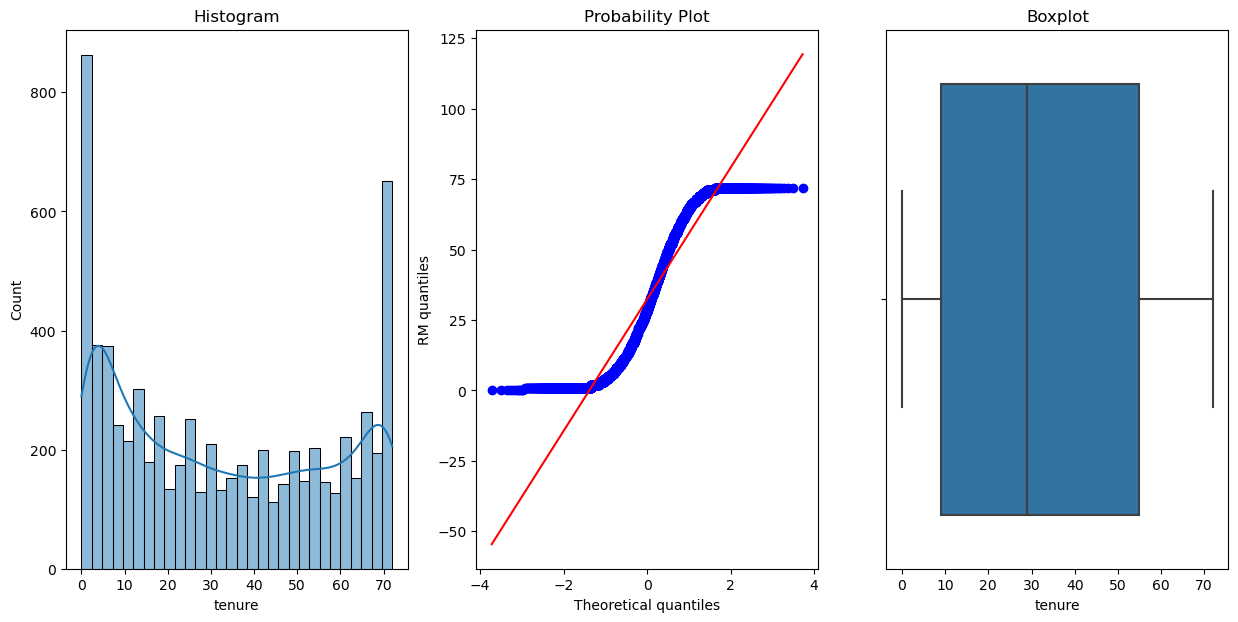

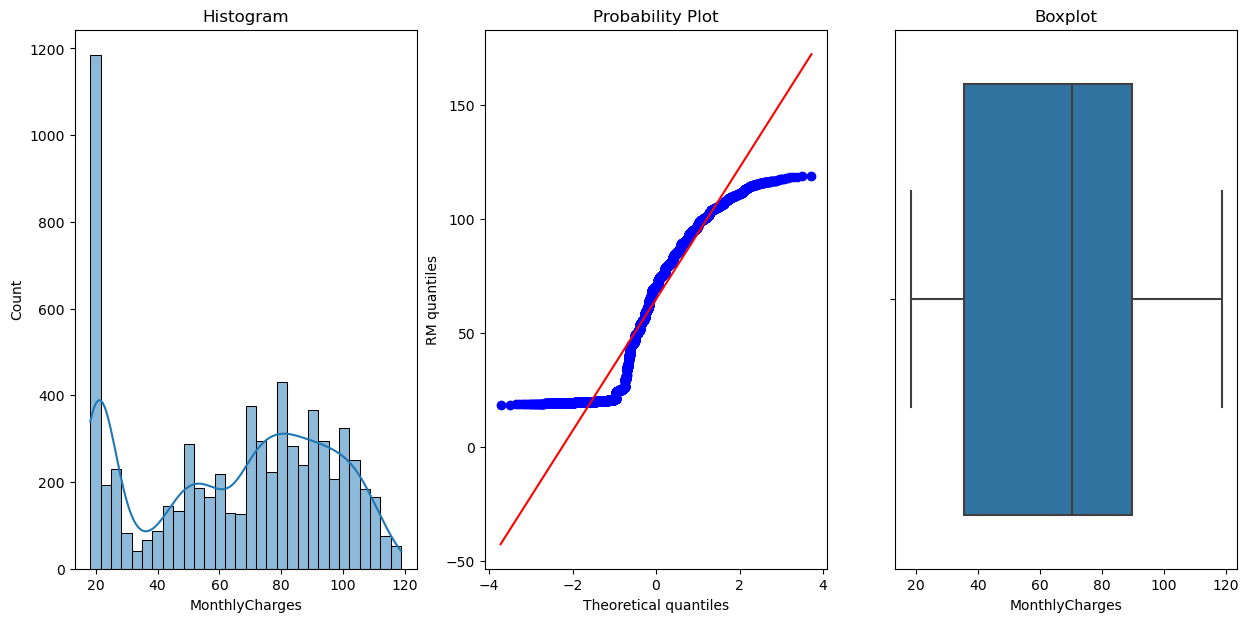

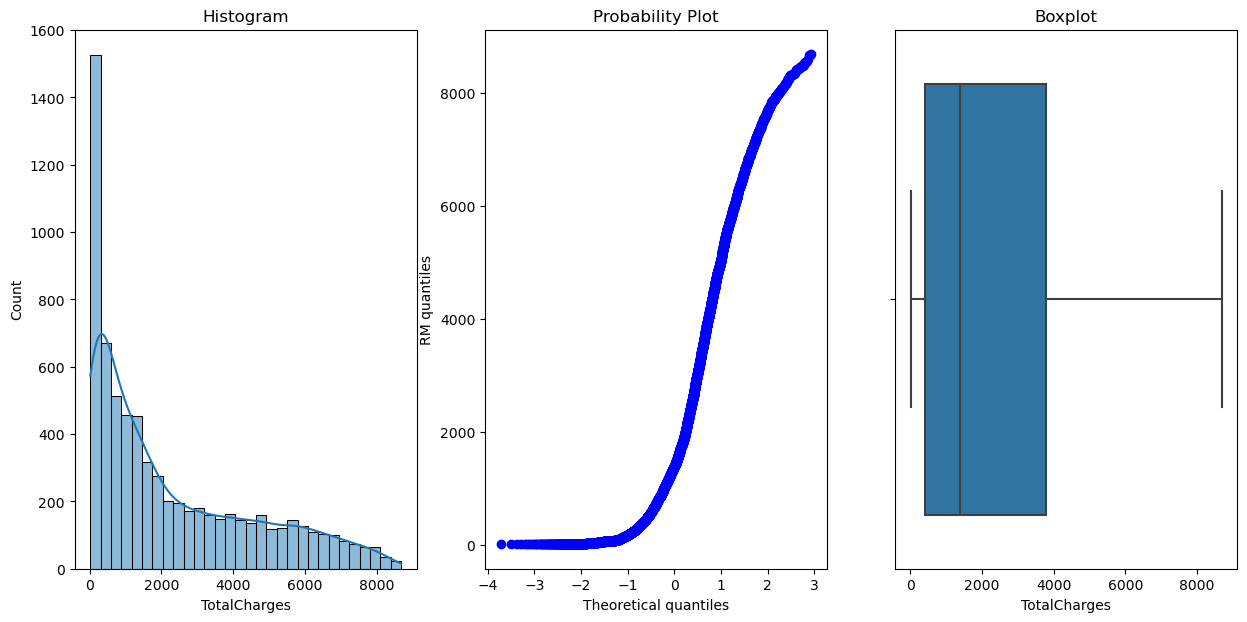

In [14]:
#plotting numerical features with probability distribution and checking outlier
for feature in numerical_feature:
    if feature != 'SeniorCitizen':
        plt.figure(figsize=(15,7))
        
        plt.subplot(1,3,1)
        sns.histplot(data=data,x=feature,bins=30,kde=True)
        plt.title('Histogram')
        
        plt.subplot(1,3,2)
        stats.probplot(data[feature],dist='norm',plot=plt)
        plt.ylabel('RM quantiles')
        
        plt.subplot(1,3,3)
        sns.boxplot(x=data[feature])
        plt.title('Boxplot')
#After ploting histogram probability distribution and box plot to find numerical value are in normally distribution
#and our dataset has no outlier dataset.So, we don't want to remove the outlier in our dataset

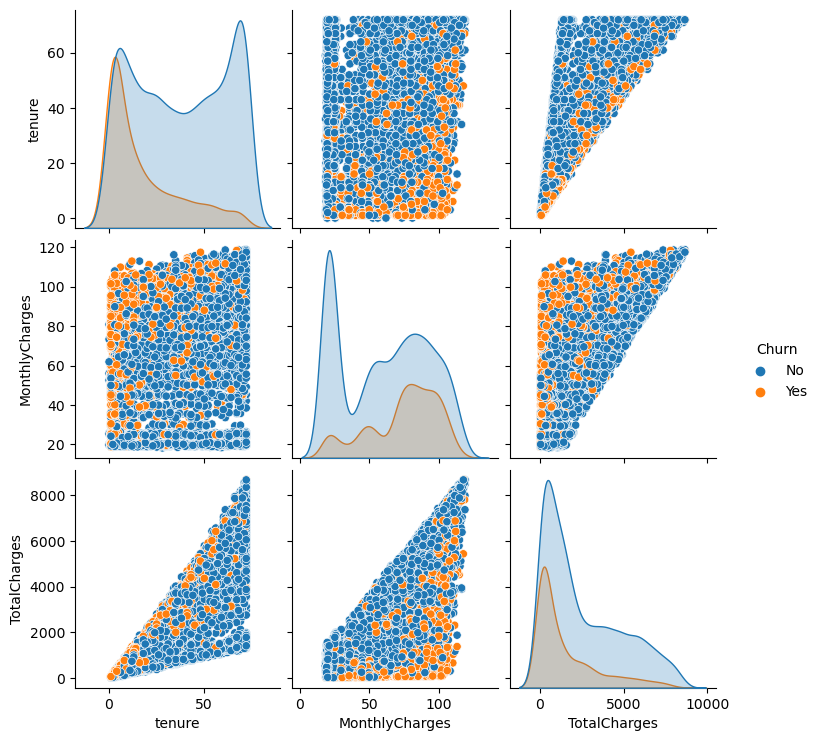

In [16]:
sns.pairplot(data.drop(columns='SeniorCitizen'),hue='Churn',kind='scatter')

0    0.84
1    0.16
Name: SeniorCitizen, dtype: float64


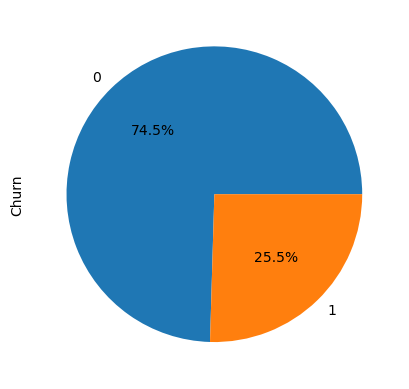

In [29]:
data[data['Churn']=='Yes'].groupby(['SeniorCitizen']).count()['Churn'].plot(kind='pie',autopct='%.1f%%')
print(np.round(data['SeniorCitizen'].value_counts(normalize=True),2))
#Senior citizens are responsible more for the churn than the younger people because
#they account for ~25.5% of churn even though they are only ~16.2% of the prople

<Figure size 640x480 with 0 Axes>

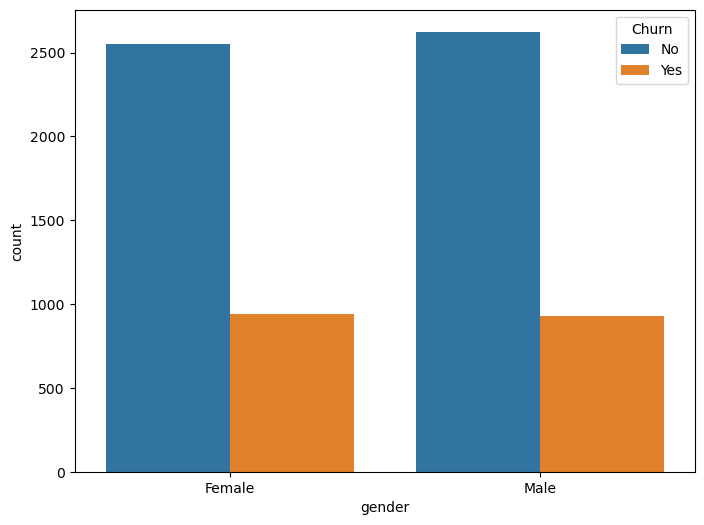

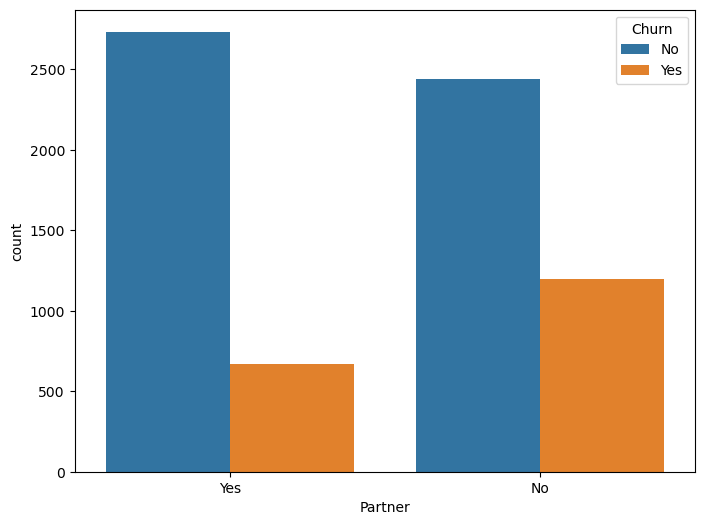

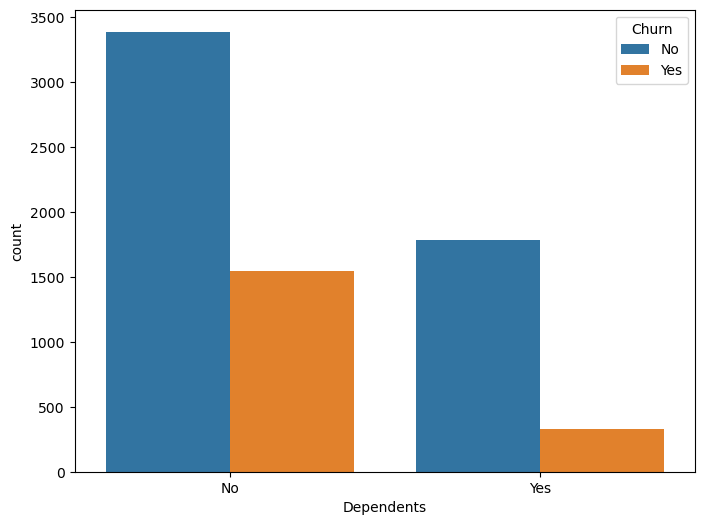

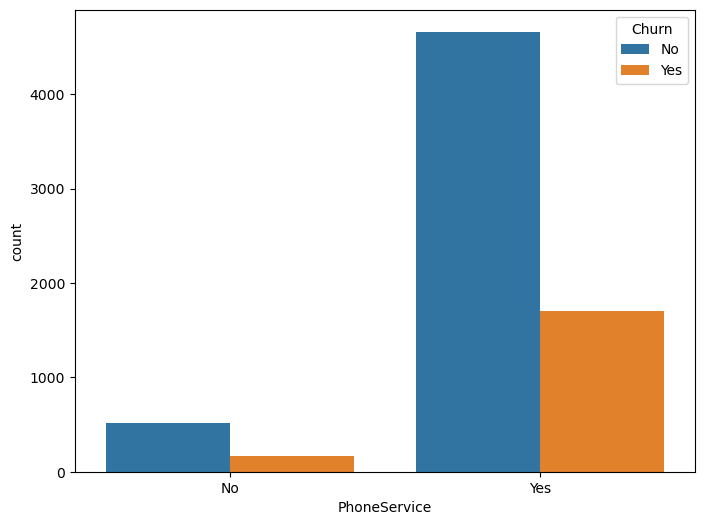

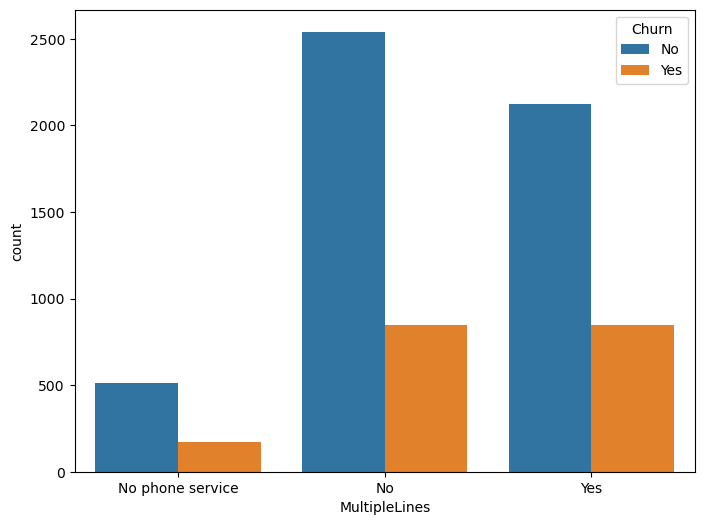

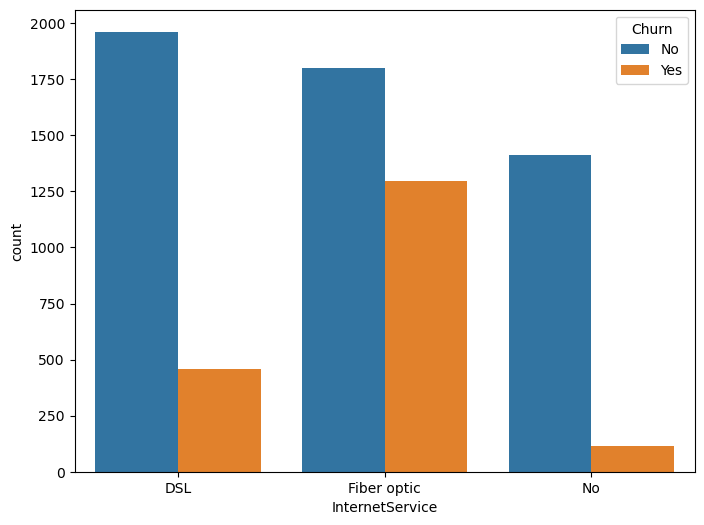

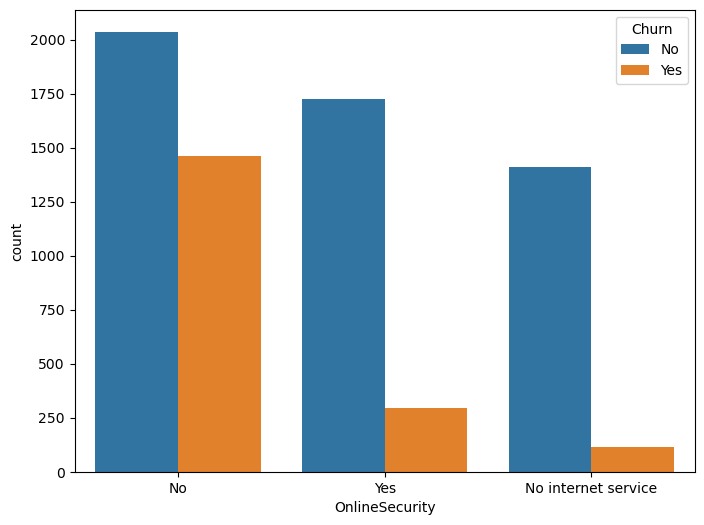

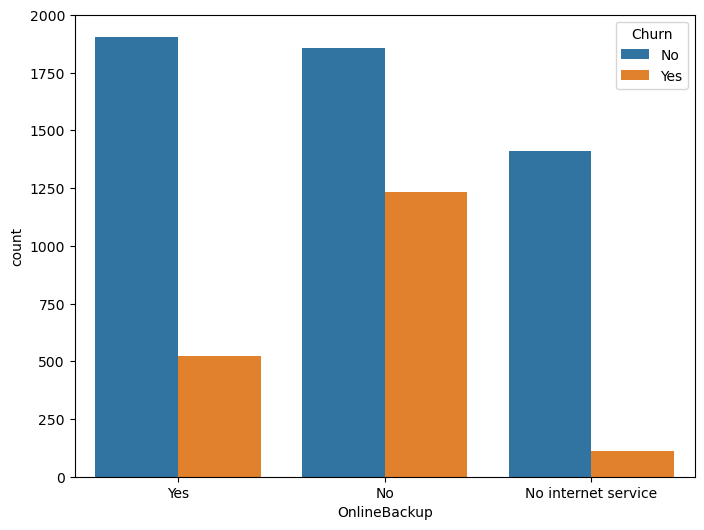

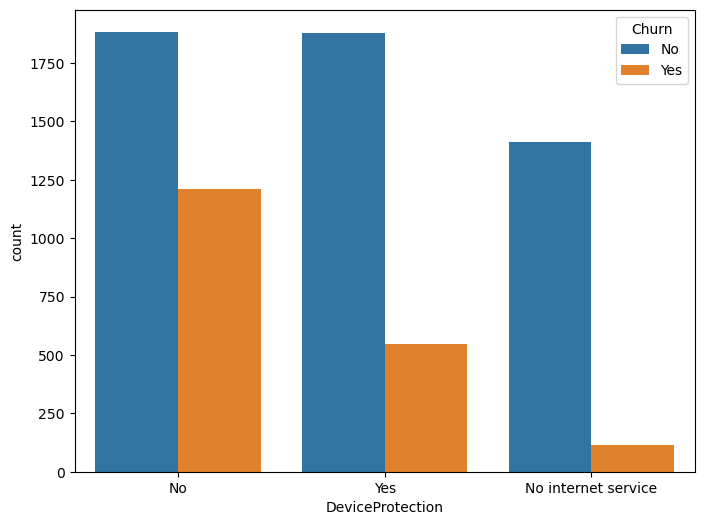

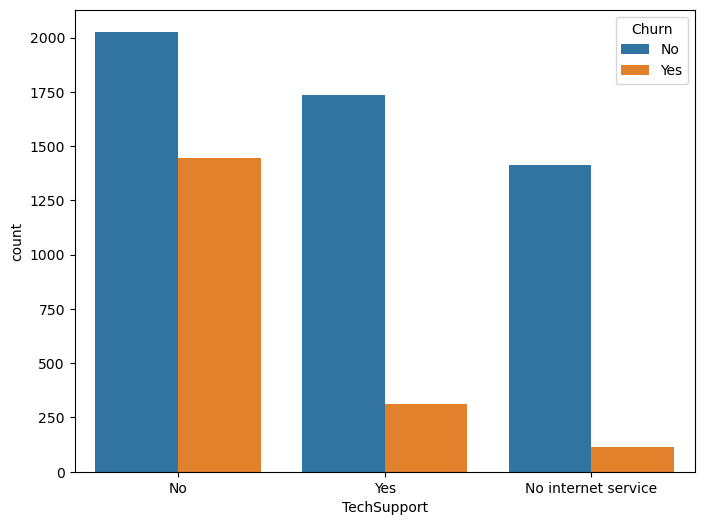

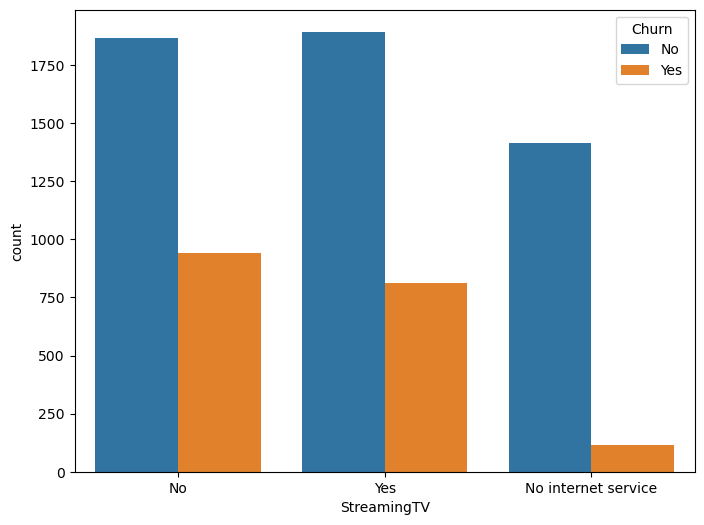

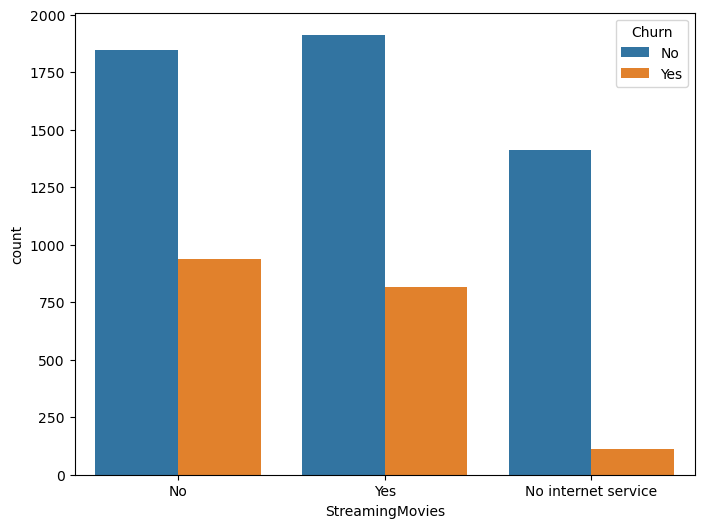

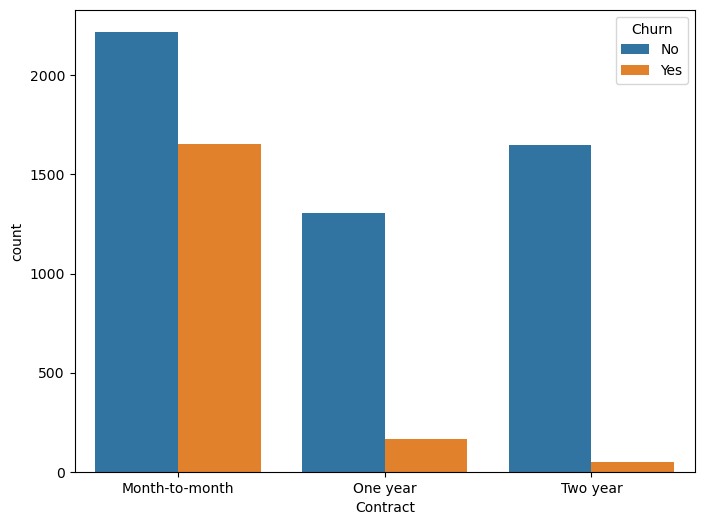

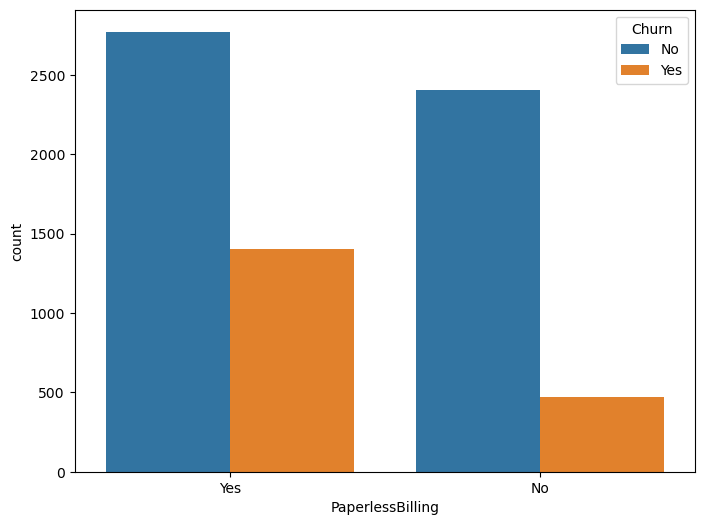

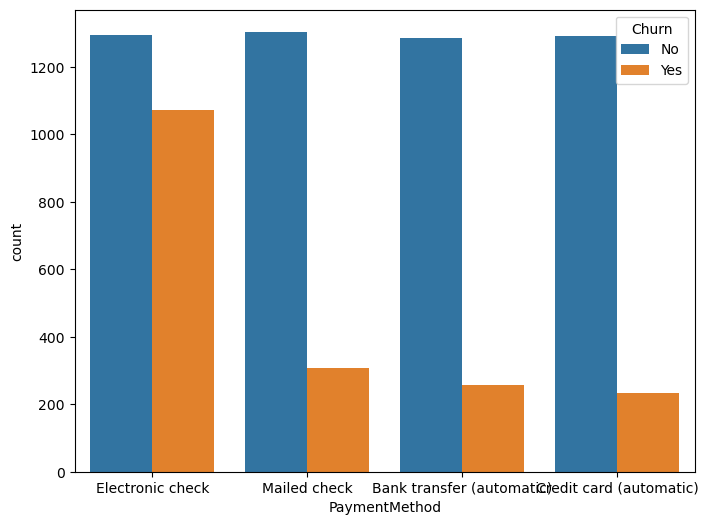

In [41]:
for i, feature in enumerate(categorical_feature):
    if feature not in ['TotalCharges','customerID','Churn']:
            plt.figure(i)
            plt.figure(figsize=(8,6))
            sns.countplot(data=data, x=feature, hue='Churn')

In [42]:
data.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [43]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp_mean = IterativeImputer(random_state=101)
data[['MonthlyCharges','TotalCharges']]=imp_mean.fit_transform(data[['MonthlyCharges','TotalCharges']])

In [46]:
data.isnull().sum()/len(data)

customerID          0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

In [19]:
categorical_feature

['customerID',
 'gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [53]:
print(data[categorical_feature].nunique())

customerID          7043
gender                 2
Partner                2
Dependents             2
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
Churn                  2
dtype: int64


In [54]:
data.head(1)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No


In [55]:
categorical_feature.append('SeniorCitizen')


In [56]:
numerical_feature.remove('SeniorCitizen')

In [57]:
encoder=LabelEncoder()
for feature in categorical_feature:
    data[feature]=encoder.fit_transform(data[feature])

In [58]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5375,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,2,29.85,29.85,0
1,3962,1,0,0,0,34,1,0,0,2,...,2,0,0,0,1,0,3,56.95,1889.50,0
2,2564,1,0,0,0,2,1,0,0,2,...,0,0,0,0,0,1,3,53.85,108.15,1
3,5535,1,0,0,0,45,0,1,0,2,...,2,2,0,0,1,0,0,42.30,1840.75,0
4,6511,0,0,0,0,2,1,0,1,0,...,0,0,0,0,0,1,2,70.70,151.65,1


<Axes: >

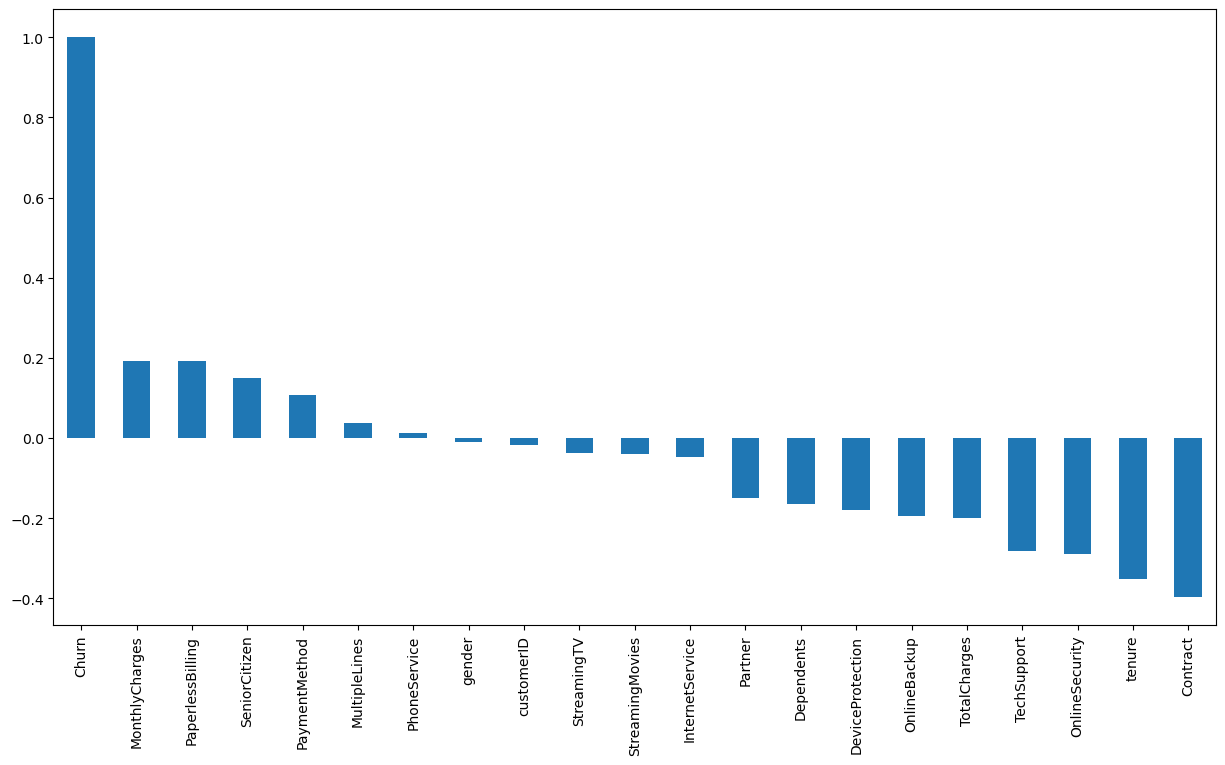

In [63]:
plt.figure(figsize=(15,8))
data.corr()['Churn'].sort_values(ascending=False).plot(kind='bar')

<Axes: >

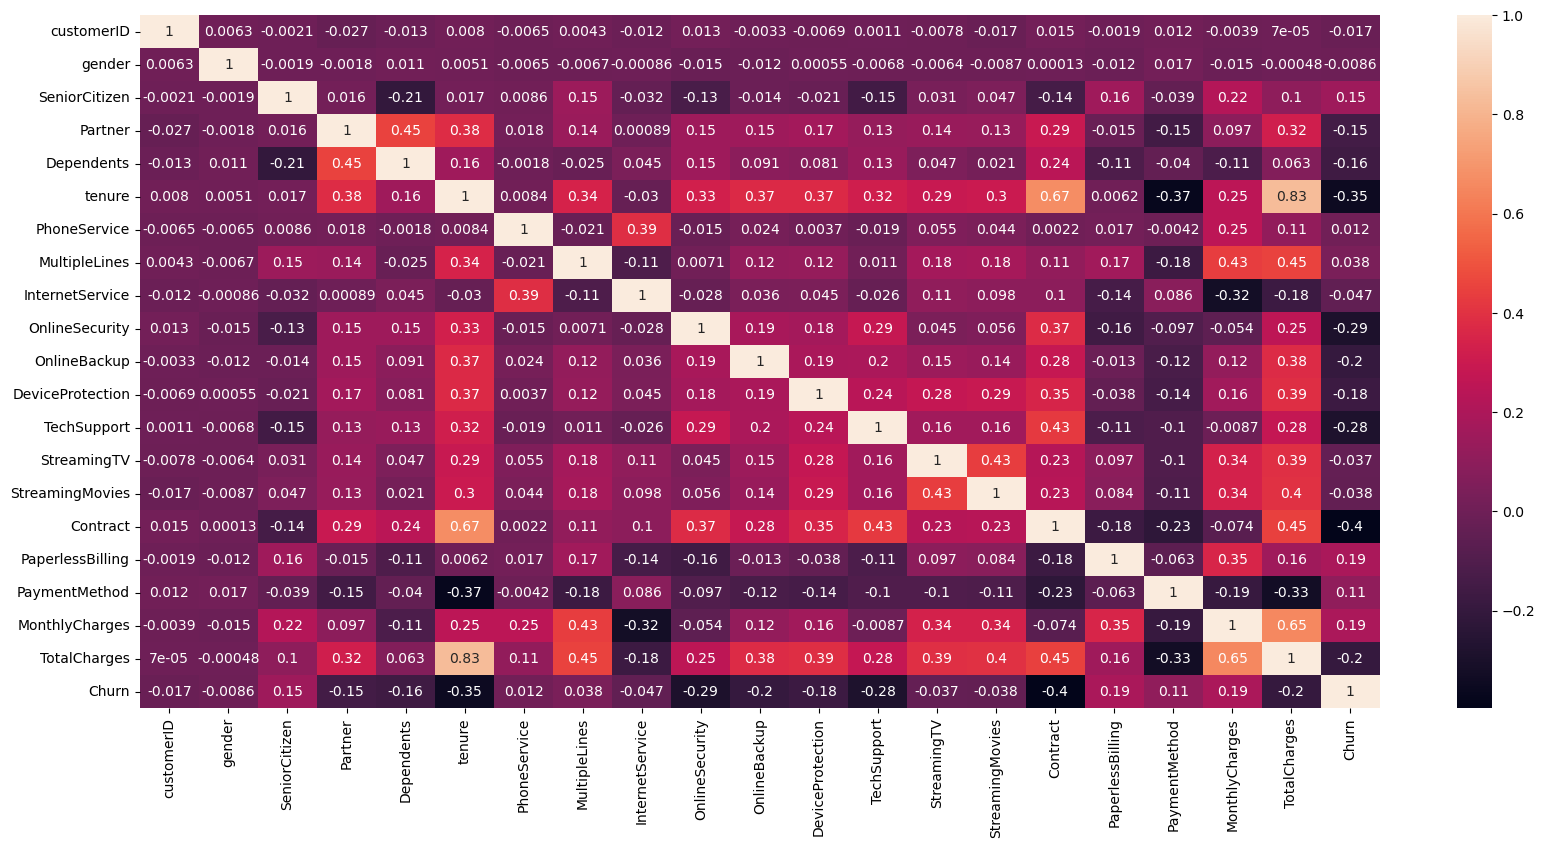

In [64]:
plt.figure(figsize=(20,9))
sns.heatmap(data.corr(),annot=True)

In [65]:
X=data.drop(columns=['Churn','customerID'])
y=data['Churn']
#Iam using ensemble methods, No need to perform feature scaling for ensemble techniques,
#its prediction based on the creating multiple decision trees
#also dropping customerId since it is of no use

In [66]:
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65


In [67]:
from sklearn.ensemble import RandomForestClassifier
pmodel=RandomForestClassifier(random_state=0,n_jobs=-1)
pmodel.fit(X,y)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [68]:
from sklearn.inspection import permutation_importance
perm=permutation_importance(pmodel,X,y,n_repeats=10,n_jobs=-1)

In [69]:
perm.importances_mean

array([0.02728951, 0.020744  , 0.02426523, 0.02009087, 0.10221497,
       0.00207298, 0.02611103, 0.03907426, 0.04587534, 0.0292631 ,
       0.02124095, 0.04794832, 0.0198353 , 0.02003408, 0.10147664,
       0.04705381, 0.0566236 , 0.10748261, 0.09944626])

In [70]:
feature_importances=pd.Series(data=perm.importances_mean,index=X.columns)
print(feature_importances.sort_values(ascending=False))

MonthlyCharges      0.107483
tenure              0.102215
Contract            0.101477
TotalCharges        0.099446
PaymentMethod       0.056624
TechSupport         0.047948
PaperlessBilling    0.047054
OnlineSecurity      0.045875
InternetService     0.039074
OnlineBackup        0.029263
gender              0.027290
MultipleLines       0.026111
Partner             0.024265
DeviceProtection    0.021241
SeniorCitizen       0.020744
Dependents          0.020091
StreamingMovies     0.020034
StreamingTV         0.019835
PhoneService        0.002073
dtype: float64


In [71]:
top10features = feature_importances.sort_values(ascending=False)[0:10].index
#X_columns=feature_importances.index
X_columns=X.columns
top10features

Index(['MonthlyCharges', 'tenure', 'Contract', 'TotalCharges', 'PaymentMethod',
       'TechSupport', 'PaperlessBilling', 'OnlineSecurity', 'InternetService',
       'OnlineBackup'],
      dtype='object')

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X[top10features], y, test_size=0.2)


In [73]:
print(X_train.shape)
print(y_train.shape)

(5634, 10)
(5634,)


In [125]:
from sklearn.metrics import accuracy_score, f1_score, auc, matthews_corrcoef
logit=LogisticRegression()
rfc=RandomForestClassifier()
dtc=DecisionTreeClassifier()
gbc=GradientBoostingClassifier()
models_dict={'logistic':logit,'random':rfc,'decision':dtc,'gradient':gbc}

for name,model in models_dict.items():
    model.fit(X_train,y_train)
    pred=model.predict(X_test)
    print(model)
    print(f'F1_Score for the is {f1_score(y_test,pred)}')
    print(f' Matthews correlation coefficient is {matthews_corrcoef(y_test,pred)}')
    print(f'Accuracy score for the is {accuracy_score(y_test,pred)} \n')
    

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()
F1_Score for the is 0.5921787709497207
 Matthews correlation coefficient is 0.45337924689981784
Accuracy score for the is 0.7927608232789212 

RandomForestClassifier()
F1_Score for the is 0.558139534883721
 Matthews correlation coefficient is 0.41710488502228177
Accuracy score for the is 0.7842441447835344 

DecisionTreeClassifier()
F1_Score for the is 0.49051490514905155
 Matthews correlation coefficient is 0.30988560797479725
Accuracy score for the is 0.7331440738112136 

GradientBoostingClassifier()
F1_Score for the is 0.5718562874251497
 Matthews correlation coefficient is 0.4430089833951683
Accuracy score for the is 0.7970191625266146 



In [106]:
#balancing the class
st=SMOTE(random_state=101)
X_train_st,y_train_st = st.fit_resample(X_train,y_train)
print(f'The number of classes before fit is {Counter(y_train)}')
print(f'The number of classes after fit is {Counter(y_train_st)}')

The number of classes before fit is Counter({0: 4128, 1: 1506})
The number of classes after fit is Counter({0: 4128, 1: 4128})


In [107]:
# splitting the over sampling dataset 
X_train_sap, X_test_sap, y_train_sap, y_test_sap = train_test_split(X_train_st, y_train_st, test_size=0.2)

In [120]:
param_grid = {'C':[1,10,100],
             'fit_intercept': [True,False],
             'max_iter': [100,1000,10000]}

In [121]:
log_estimator = RandomizedSearchCV(estimator=logit, param_distributions=param_grid,n_iter=100, verbose=0,n_jobs=-1)
log_estimator.fit(X_train_sap, y_train_sap)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 18 is smaller than n_iter=100. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(estimator=LogisticRegression(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': [1, 10, 100],
                                        'fit_intercept': [True, False],
                                        'max_iter': [100, 1000, 10000]})

In [124]:
log_estimator.best_estimator_

LogisticRegression(C=10, max_iter=1000)

In [127]:
pred = log_estimator.predict(X_test_sap)

print(f'F1_Score  is {f1_score(y_test_sap,pred)}')
print(f' Matthews correlation coefficient is {matthews_corrcoef(y_test_sap,pred)}')

F1_Score  is 0.7965217391304348
 Matthews correlation coefficient is 0.5794701286665407


After Oversampling our Logistic Regression model's has improved. 
F1_score - 59.2% -> 79.7%
Matthews Correlation coefficent -45.3% ->58.0%


In [130]:
import pickle
filename =r'C:\Users\tusha\Documents\Data Science\Python\Telco Customer Churn\model.sav'
pickle.dump(log_estimator,open(filename,'wb'))
load_model=pickle.load(open(filename,'rb'))